# Basic water mass analysis example notebook for MPAS-Ocean

This notebook demonstrates basic usage of the water mass analysis code in

https://github.com/MPAS-Dev/MPAS-QuickViz/tree/master/ocean/AMOC/watermassanalysis

Two code modules are referenced:

   1. [`watermasstools.py`](https://github.com/MPAS-Dev/MPAS-QuickViz/blob/master/ocean/AMOC/watermassanalysis/modules/watermasstools.py)
   2. [`postprocesstools.py`](https://github.com/MPAS-Dev/MPAS-QuickViz/blob/master/ocean/AMOC/watermassanalysis/modules/postprocesstools.py)

Additionally, three `yaml` definitions files are referenced:

   1. [`paths_LR.yaml`](https://github.com/MPAS-Dev/MPAS-QuickViz/blob/master/ocean/AMOC/watermassanalysis/yaml/paths_LR.yaml)
   2. [`paths_HR.yaml`](https://github.com/MPAS-Dev/MPAS-QuickViz/blob/master/ocean/AMOC/watermassanalysis/yaml/paths_HR.yaml)
   3. [`variable_combinations.yaml`](https://github.com/MPAS-Dev/MPAS-QuickViz/blob/master/ocean/AMOC/watermassanalysis/yaml/variable_combinations.yaml)

This workflow has 2 additional dependencies beyond the `e3sm_unified` environment

   1. [`fastjmd95`](https://github.com/xgcm/fastjmd95) -- A numba-accelerated package for the Jackett and McDougall (1995) equation of state
   2. [`tqdm`](https://github.com/tqdm/tqdm) -- My preferred statusbar package

***

In [1]:
import numpy as np
import xarray as xr
import pandas as pd
import yaml
import sys
import matplotlib.pyplot as plt
from tqdm import tqdm

# Import modules from path
sys.path.append('../modules/')
import postprocesstools as pptools
import watermasstools as wmttools

# Set plot font sizes
plt.rcParams.update({'font.size': 10, 'axes.titlesize': 'medium'})

***

### Compute water mass transformation

This cell computes water mass transformation in the LR and HR for the listed regions over the first 12 simulation months. 1D (outcrop-integrated) and 2D (remapped) results are both returned.

In [2]:
# Regions
regions = ['Greenland Sea', 'Iceland Basin', 'Irminger Sea', 'Labrador Sea', 'Norwegian Sea', 'North Atlantic Ocean']

# Initialize storage dict
meshes = ['LR', 'HR']
wmt = {mesh: {'1D': [], '2D': []} for mesh in meshes}

# Months to process
months = np.arange(1, 13, dtype=int)

# Loop though meshes
for mesh in meshes:

    # Load paths
    with open(f'../yaml/paths_{mesh}.yaml') as f:
        paths = yaml.safe_load(f)
    resultspath = paths['results']['1947-1957'] + '/' + paths['prefix']

    # Load mask variables
    with xr.open_dataset(paths['maskfile']) as ds:
        regionNames = ds.regionNames.values.astype(str)
        regionMasks = ds.regionCellMasks.values

    # Build subdomain to include only points in region list
    index = np.isin(regionNames, regions)
    subdomain, = np.where(regionMasks[:, index].sum(axis=1).astype(bool))

    # Load mesh variables and build coords dict
    with xr.open_dataset(paths['meshfile']) as ds:
        coords = {
            'area': ds.areaCell.values[subdomain],
            'nCells': ds.nCells.values[subdomain],
            'regionNames': regionNames,
            'regionMasks': regionMasks[subdomain, :].astype(bool),
        }

    # Initialize remapping variables (define bbox here if you don't want the whole globe)
    remapvars = pptools.build_remapper(paths['meshfile'], bbox=[-100, 20, 0, 80])
    
    # Loop through months
    for month in tqdm(months, desc=f'Loading {mesh} results'):
        
        # Load results
        with xr.open_dataset(resultspath + f'.0001-{month:02d}-01.nc') as ds:

            # Get S, T and statevars
            names, prefix = ['salinity', 'temperature'], 'timeMonthly_avg_activeTracers_'
            S, T = [ds[prefix + name][0, :, 0].values[subdomain] for name in names]
            sigmaTheta, heatFactor, saltFactor = wmttools.calc_state_variables(S, T)

            # Get buoyancy fluxes
            fluxes = wmttools.build_combined_fluxes(ds, heatFactor, saltFactor, subdomain=subdomain)

        # Calculate 1D water mass transformation over regions
        wmt[mesh]['1D'].append(wmttools.calc_wmt(fluxes, sigmaTheta, coords, regions=regions))
        
        # Calculate 2D water mass transformation
        wmt[mesh]['2D'].append(wmttools.calc_wmt(fluxes, sigmaTheta, coords, remapvars=remapvars))
    
    # Concatenate months
    for ctgy in wmt[mesh]:
        wmt[mesh][ctgy] = xr.concat(wmt[mesh][ctgy], pd.Index(months, name='months'))

Loading HR results: 100%|██████████| 12/12 [01:49<00:00,  9.09s/it]


***

### Output data structures

Here is a preview of the `xarray.Dataset` structure for the LR results for 1D and 2D.

In [3]:
# xr.Dataset structure for the 1D results
wmt['LR']['1D']

<xarray.Dataset>
Dimensions:              (months: 12, sigmaBins: 81, regionNames: 6)
Coordinates:
  * sigmaBins            (sigmaBins) float64 21.0 21.1 21.2 ... 28.8 28.9 29.0
  * regionNames          (regionNames) <U20 'Greenland Sea' ... 'North Atlant...
  * months               (months) int64 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    heatTransformation   (months, sigmaBins, regionNames) float64 0.0 ... 0.0
    saltTransformation   (months, sigmaBins, regionNames) float64 0.0 ... 0.0
    totalTransformation  (months, sigmaBins, regionNames) float64 0.0 ... 0.0

In [4]:
# xr.Dataset structure for the 2D results
wmt['LR']['2D']

<xarray.Dataset>
Dimensions:              (months: 12, sigmaBins: 81, lat: 160, lon: 240)
Coordinates:
  * sigmaBins            (sigmaBins) float64 21.0 21.1 21.2 ... 28.8 28.9 29.0
  * lat                  (lat) float64 0.25 0.75 1.25 1.75 ... 78.75 79.25 79.75
  * lon                  (lon) float64 -99.75 -99.25 -98.75 ... 19.25 19.75
  * months               (months) int64 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    heatTransformation   (months, sigmaBins, lat, lon) float64 0.0 0.0 ... nan
    saltTransformation   (months, sigmaBins, lat, lon) float64 0.0 0.0 ... nan
    totalTransformation  (months, sigmaBins, lat, lon) float64 0.0 0.0 ... nan

***

### Plots

1D transformation summary

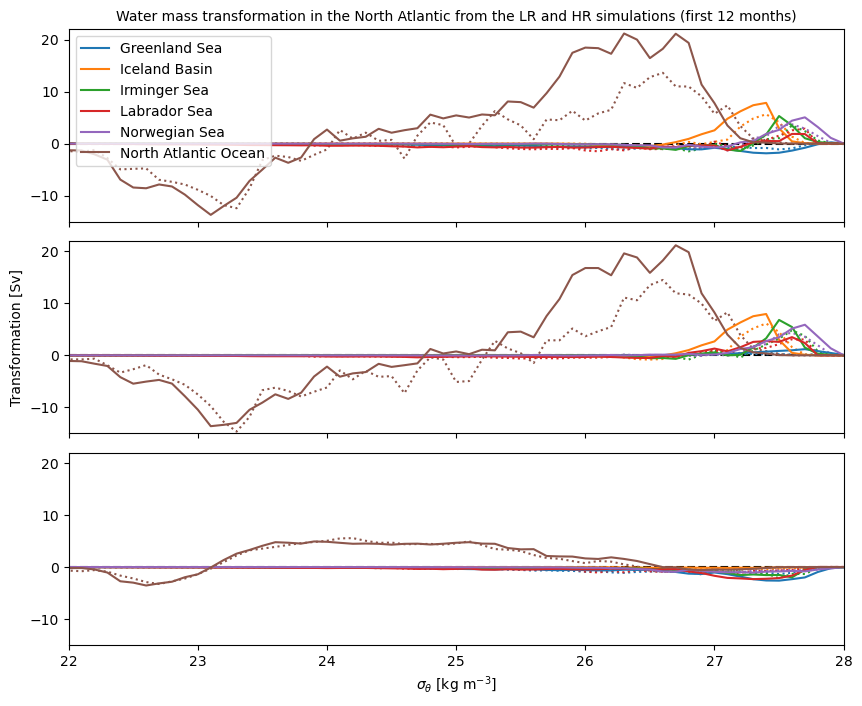

In [5]:
# Make figure
fig, axs = plt.subplots(3, 1, figsize=(10, 8), gridspec_kw={'hspace': 0.1})
palette = plt.get_cmap('tab10').colors
xlim, ylim = [22, 28], [-15, 22]

# Loop through panels and transformation categories
for ax, ctgy in zip(axs, ['total', 'heat', 'salt']):
    
    # Loop through meshes and regions
    for mesh, ls in zip(['LR', 'HR'], [':', '-']):
        for region, color in zip(regions, palette):
            
            # Plot transformation averaged over first 12 months of simulation
            label = region if ls == '-' else None
            y = wmt[mesh]['1D'][ctgy + 'Transformation'].sel(regionNames=region).mean(dim='months')
            x = y.sigmaBins
            ax.plot(x, y, ls, color=color, label=label)
    
    # Formatting
    ax.plot(xlim, [0, 0], 'k--', zorder=-10)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    if ctgy != 'salt':
        ax.xaxis.set_ticklabels('')

# Final formatting
axs[2].set_xlabel('$\\sigma_{\\theta}$ [kg m$^{-3}$]')
axs[1].set_ylabel('Transformation [Sv]')
axs[0].set_title('Water mass transformation in the North Atlantic from the LR and HR simulations (first 12 months)')
axs[0].legend()
plt.show()

2D transformation summary

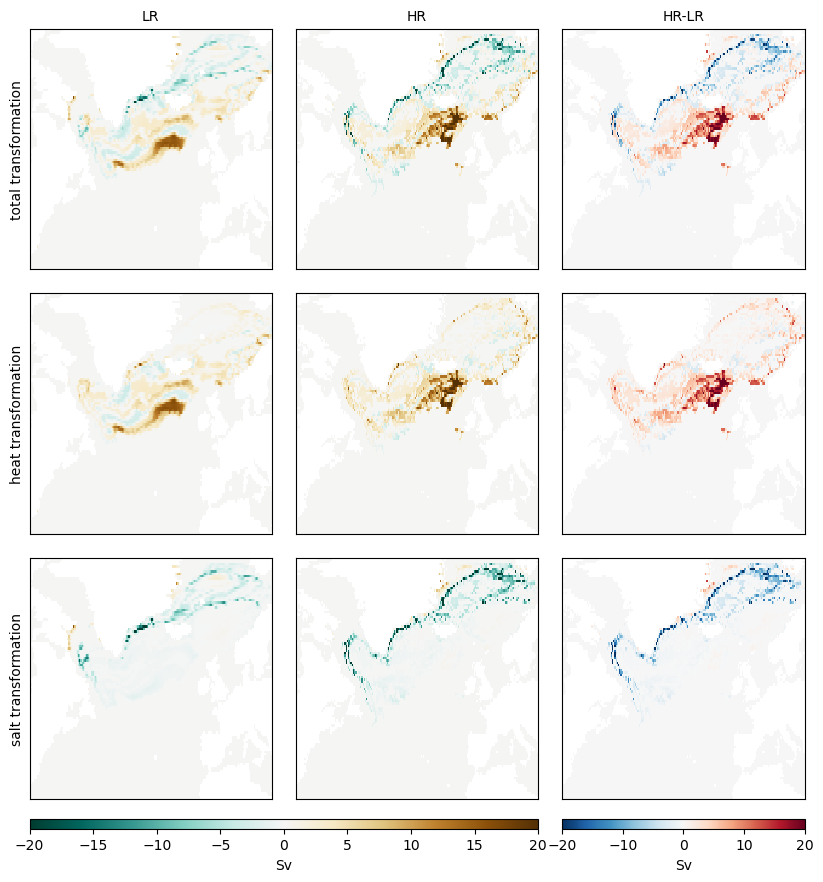

In [6]:
# Make figure
fig, axs = plt.subplots(3, 3, figsize=(10, 10), gridspec_kw={'hspace': 0.1, 'wspace': 0.1})
xlim, ylim = [-80, 20], [30, 80]

# Loop through rows and transformation categories
for row, ctgy in zip(axs, ['total', 'heat', 'salt']):
    row[0].set_ylabel(ctgy + ' transformation')
    
    # Loop through panels and meshes
    residual = []
    for ax, mesh in zip(row, meshes):
            
        # Plot transformation averaged over first 12 months of simulation at sigma=27.3
        z = wmt[mesh]['2D'][ctgy + 'Transformation'].sel(sigmaBins=27.3).mean(dim='months')
        x, y = z.lon, z.lat
        c1 = ax.pcolormesh(x, y, z, vmin=-20, vmax=20, cmap='BrBG_r')
        residual.append(z)
    
    # Plot residual
    residual = np.subtract(*residual)
    c2 = row[2].pcolormesh(x, y, z, vmin=-20, vmax=20, cmap='RdBu_r')
    
# Formatting
pos = []
for col, title in zip(axs.T, meshes + ['HR-LR']):
    col[0].set_title(title)
    pos.append(col[2].get_position())
    for ax in col:
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)
        ax.xaxis.set_ticks([])
        ax.yaxis.set_ticks([])

# Add colorbars
cax1 = fig.add_axes([pos[0].x0, 0.08, pos[1].x1 - pos[0].x0, 0.01])
cax2 = fig.add_axes([pos[2].x0, 0.08, pos[2].width, 0.01])
fig.colorbar(c1, cax1, orientation='horizontal', label='Sv')
fig.colorbar(c2, cax2, orientation='horizontal', label='Sv')
plt.show()